## Import various python functions and modules that we need.

In [2]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R
workDir = '/home/chantal/Chazy/data/'
figDir = '/home/chantal/Chazy/BulkSIP/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'


nprocs = 20

##Import R libraries we'll use.

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr) ;library(dplyr)
library(RColorBrewer)
library(stats)
library(ape)
library(stringr)
library(ade4)
library(reshape2)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

## Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [6]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
#physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE) %>%
 #                           transform_sample_counts(function(x) x/sum(x))
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS",
                           physeq.Bulk)

print(physeq.Bulk.core)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [7]:
%%R
physeq.Bulk.core.r.filt = physeq.Bulk.core %>% filter_taxa(function(x) sum(x) > 0, TRUE) %>%
                            transform_sample_counts(function(x) x/sum(x))
physeq.Bulk.core.RFN = filter_taxa(physeq.Bulk.core.r.filt, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
    
physeq.Bulk.core.RFN
                      

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


### Calculate Unifrac distances between samples.

In [8]:
%%R
method = 'unifrac'

In [9]:
%%R
registerDoParallel(cores=20)
wunif.dist.nopas = distance(physeq.Bulk.core.RFN, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [10]:
%%R
# Removing samples w/o soil temperature

physeq.Bulk.m = physeq.Bulk.core.RFN %>% sample_data

physeq.notemp = prune_samples(!(is.na(physeq.Bulk.m$Soil_Temp)), physeq.Bulk.core.RFN)

physeq.notemp 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [11]:
%%R
registerDoParallel(cores=20)
wunif.dist.notemp =  distance(physeq.notemp, 
                      method = method, 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [12]:
%%R
# Removing samples w/o soil moisture
physeq.Bulk.m = physeq.Bulk.core.RFN %>% sample_data

physeq.nomoist = prune_samples(!(is.na(physeq.Bulk.m$Soil_Moisture)), physeq.Bulk.core.RFN)

physeq.nomoist

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 159 samples ]
sample_data() Sample Data:       [ 159 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [13]:
%%R
registerDoParallel(cores=20)
wunif.dist.nomoist = phyloseq::distance(physeq.nomoist, 
                      method = method, 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## Distance vs Time

In [14]:
%%R
library(reshape2)

df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))

In [15]:
%%R
head(df)


              T1             T2      value
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000
2        S.NTR.2 Nov.NTR.4.2015 0.13352784
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550
5      July.NTR1 Nov.NTR.4.2015 0.10557632
6      July.NTR4 Nov.NTR.4.2015 0.08459175


In [16]:
%%R
physeq.test = sample_data(physeq.Bulk.core.RFN)

physeq.test = plyr::rename(physeq.test, c("Full.sample"="T1", "Sample_Date"="SD_T1"))

head(physeq.test)

Sample Data:        [6 samples by 25 sample variables]:
                           T1 Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment Day Replicate Pool Land_Management Gradient
Nov.NTR.4.2015  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
S.NTR.2         ctactata      <NA>  NA         2    5             NTR     <NA>
June15.NTH.2    ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
Oct.NTR.1.2015  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
July.NTR1       cgttacta      <NA>  NA

In [17]:
%%R

Test = full_join(df, physeq.test, by = 'T1')

In [18]:
%%R

physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))


In [19]:
%%R
Test2 = full_join(Test, physeq.test2, by = 'T2')
print(head(Test))
print(length(Test2$T2))

              T1             T2      value Fraction PrimerF PrimerR Barcode
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000       NA    515f    806r      84
2        S.NTR.2 Nov.NTR.4.2015 0.13352784       NA    515f    806r     145
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568       NA    515f    806r      84
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550       NA    515f    806r      46
5      July.NTR1 Nov.NTR.4.2015 0.10557632       NA    515f    806r     122
6      July.NTR4 Nov.NTR.4.2015 0.08459175       NA    515f    806r     125
  Rev.index Fwd.index Treatment Day Replicate Pool Land_Management Gradient
1  gtctatga  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
2  tagtctcc  ctactata      <NA>  NA         2    5             NTR     <NA>
3  gtctatga  ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
4  ctgcgtag  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
5  actcactg  cgttacta      <NA>  NA         1    5             NTR     <NA>
6  actcactg 

In [20]:
%%R
Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)

In [21]:
%%R
head(Test2)

              T1             T2      value    SD_T1    SD_T2
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000 11/25/15 11/25/15
2        S.NTR.2 Nov.NTR.4.2015 0.13352784  9/24/14 11/25/15
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568  6/17/15 11/25/15
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550 10/27/15 11/25/15
5      July.NTR1 Nov.NTR.4.2015 0.10557632  7/10/14 11/25/15
6      July.NTR4 Nov.NTR.4.2015 0.08459175  7/10/14 11/25/15


In [22]:
%%R
Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))

head(Test2)

              T1             T2      value      SD_T1      SD_T2
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000 2015-11-25 2015-11-25
2        S.NTR.2 Nov.NTR.4.2015 0.13352784 2014-09-24 2015-11-25
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568 2015-06-17 2015-11-25
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550 2015-10-27 2015-11-25
5      July.NTR1 Nov.NTR.4.2015 0.10557632 2014-07-10 2015-11-25
6      July.NTR4 Nov.NTR.4.2015 0.08459175 2014-07-10 2015-11-25


In [23]:
%%R
Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

Test2$Day_rel = as.numeric(Test2$Day)

head(Test2)

              T1             T2      value      SD_T1      SD_T2      Day
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000 2015-11-25 2015-11-25   0 days
2        S.NTR.2 Nov.NTR.4.2015 0.13352784 2014-09-24 2015-11-25 427 days
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568 2015-06-17 2015-11-25 161 days
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550 2015-10-27 2015-11-25  29 days
5      July.NTR1 Nov.NTR.4.2015 0.10557632 2014-07-10 2015-11-25 503 days
6      July.NTR4 Nov.NTR.4.2015 0.08459175 2014-07-10 2015-11-25 503 days
  Day_rel
1       0
2     427
3     161
4      29
5     503
6     503


In [24]:
%%R
testunique = unique(Test2$Day_rel)
(testunique)

 [1]   0 427 161  29 503 392 104 364  63 209 132 266 398  76  35 323 218 295 342
[20] 231  57 203  98  48 474 363  75 335  34 180 103 111 399 139 440 294 371 288
[39]  28 329 183 260  41 105 301 155 232 146  69  77


In [25]:
%%R
test.sep = Test2 %>% tidyr::separate(T1, c('Month1', 'Treatment1', 'Rep1'))
test.sep = test.sep %>% tidyr::separate(T2, c('Month2', 'Treatment2', 'Rep2'))

test.sep$RepSame = ifelse(test.sep$Rep1 == test.sep$Rep2, 1, 0) 


head(test.sep)

  Month1 Treatment1 Rep1 Month2 Treatment2 Rep2      value      SD_T1
1    Nov        NTR    4    Nov        NTR    4 0.00000000 2015-11-25
2      S        NTR    2    Nov        NTR    4 0.13352784 2014-09-24
3 June15        NTH    2    Nov        NTR    4 0.10280568 2015-06-17
4    Oct        NTR    1    Nov        NTR    4 0.08489550 2015-10-27
5   July       NTR1 <NA>    Nov        NTR    4 0.10557632 2014-07-10
6   July       NTR4 <NA>    Nov        NTR    4 0.08459175 2014-07-10
       SD_T2      Day Day_rel RepSame
1 2015-11-25   0 days       0       1
2 2015-11-25 427 days     427       0
3 2015-11-25 161 days     161       0
4 2015-11-25  29 days      29       0
5 2015-11-25 503 days     503      NA
6 2015-11-25 503 days     503      NA


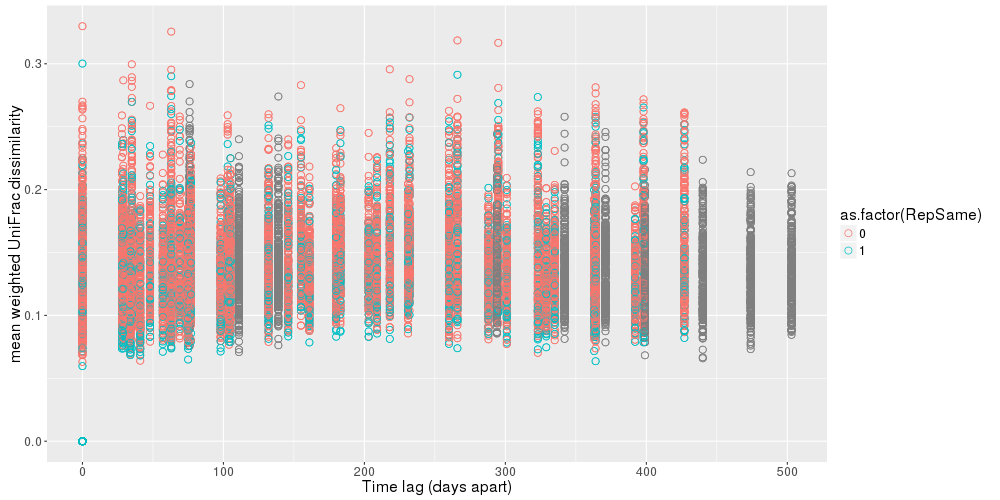

In [26]:
%%R -w 1000 -h 500
p = ggplot(data = test.sep, aes(Day_rel, value, color = as.factor(RepSame))) + geom_point(size = 3, shape = 21) +
    xlab('Time lag (days apart)') + ylab('mean weighted UniFrac dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

### Analyses to do (gstat- just temporal)
* Separate physeq and run distances on each treatment type and block and then plot sum
* Then create variograms - if much different, spatial effects seem to matter; if not, could probably do variogram with all treatments

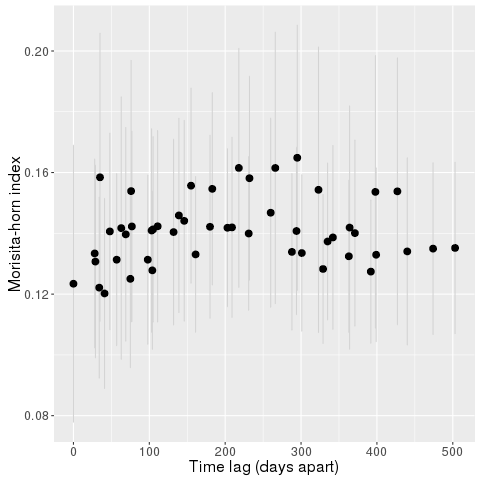

In [27]:
%%R

Test3 = Test2 %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

limits <- aes(ymax = meanval + sdval, ymin = meanval - sdval)


p = ggplot(data = Test3, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'light grey')+ geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) 
p

In [28]:
%%R
physeq.test = sample_data(physeq.Bulk.core.RFN)

physeq.test$Sample_Date = as.POSIXct(strptime(physeq.test$Sample_Date , format = "%m/%d/%y"))

physeq.test$day = round(difftime(physeq.test$Sample_Date, min(physeq.test$Sample_Date), units = "days"))

physeq.test$d = as.numeric(physeq.test$day)
time_d = dist(physeq.test$d)

In [29]:
%%R
mantel.rtest(wunif.dist.nopas, time_d, nrepet = 9999)

Monte-Carlo test
Observation: 0.06363126 
Call: mantelnoneuclid(m1 = m1, m2 = m2, nrepet = nrepet)
Based on 9999 replicates
Simulated p-value: 0.0086 


In [30]:
%%R
library(ecodist)
mantel(formula = wunif.dist.nopas ~ time_d, nperm = 10000)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘ecodist’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:vegan’:

    mantel


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:phyloseq’:

    distance


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.06363126 0.00820000 0.99190000 0.01080000 0.04344709 0.08637021 


## Semivariogram

In [31]:
%%R
library(geoR)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: --------------------------------------------------------------
 Analysis of Geostatistical Data
 For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
 geoR version 1.7-5.1 (built on 2015-04-15) is now loaded
--------------------------------------------------------------


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [32]:
%%R
head(Test3)

Source: local data frame [6 x 3]

  Day_rel   meanval      sdval
    (dbl)     (dbl)      (dbl)
1       0 0.1234293 0.04554896
2      28 0.1333922 0.03102597
3      29 0.1307167 0.03167571
4      34 0.1221377 0.02975160
5      35 0.1584510 0.04736715
6      41 0.1202277 0.03126558


In [33]:
%%R
v1 = variog(coords = Test3$Day_rel, data = Test3$meanval)


variog: computing omnidirectional variogram
Error in rep(1, nrow(geodata$coords)) : invalid 'times' argument


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in rep(1, nrow(geodata$coords)) : invalid 'times' argument

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packag

## Weighted UniFrac vs. Soil Temp

In [34]:
%%R
climate = read.csv('../515_806/Chazy-Climate.csv')

In [35]:
%%R
library(lubridate)
climate = filter(climate, !(is.na(Sample_date)))
climate$Month = months(as.Date(climate$Sample_date))
climate$Year = year(climate$Sample_date)
climate$MY = paste(climate$Month, climate$Year, sep = '-')

head(climate, n = 10)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘lubridate’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:plyr’:

    here


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   Airport       Date Fog Rain Snow AvgTemp AvgVisibility MaxTemp MinTemp
1      PBG 1404540000   0    0    0      22            16      82      60
2      PBG 1404626400   0    0    0      22            16      84      59
3      PBG 1404712800   0    1    0      21            14      75      63
4      PBG 1404799200   1    1    0      23             8      84      61
5      PBG 1404885600   0    0    0      22            16      81      63
6      PBG 1404972000   0    0    0      18            16      76      53
7      PBG 1411106400   0    0    0       6            16      55      30
8      PBG 1411192800   0    0    0      12            16      69      36
9      PBG 1411279200   0    1    0      21            15      78      61
10     PBG 1411365600   0    1    0      11            16      63      39
   Precipitation Sample_date     Month Year             MY
1           0.00  2014-07-05      July 2014      July-2014
2           0.00  2014-07-06      July 2014      July-2014
3        

In [36]:
%%R
mean_Temp = climate %>% select(Sample_date, MY, AvgTemp) %>% group_by(MY) %>% mutate(min = dense_rank(AvgTemp)) %>% 
            #filter((min != min(min))) %>% 
            summarise(mean_mean = mean(AvgTemp)) 

mean_Temp %>% as.data.frame

               MY  mean_mean
1      April-2015  8.5000000
2     August-2015 19.3333333
3       July-2014 21.3333333
4       July-2015 21.3333333
5       June-2015 18.0000000
6   November-2014  3.5000000
7   November-2015  0.6666667
8    October-2014  9.3333333
9    October-2015  5.6666667
10 September-2014 12.6666667
11 September-2015 15.6666667


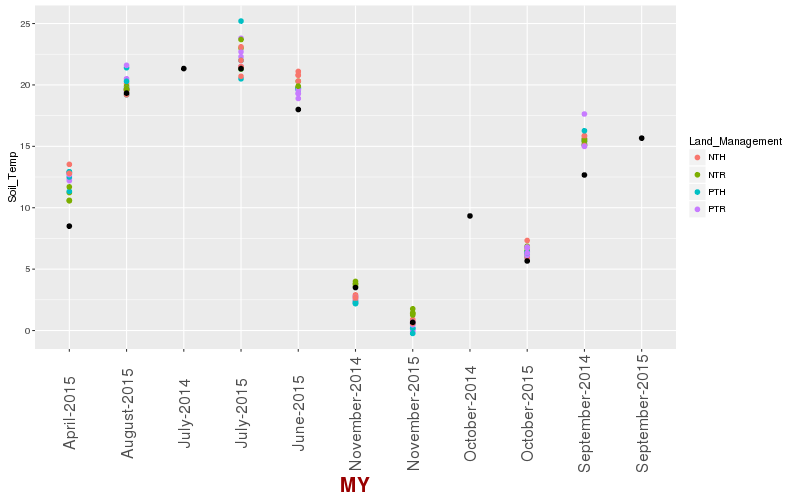

In [37]:
%%R -w 800 -h 500
physeq.m = physeq.Bulk.core.RFN %>% sample_data
only_SD = filter(climate, !(Sample_date %in% c ('2014-07-10', '2014-09-24','2014-10-29','2014-11-26','2015-04-30',
                                              '2015-06-17','2015-07-16','2015-08-13','2015-09-23', '2015-10-27',
                                              '2015-11-25')))

physeq.m$MY = paste(physeq.m$Month, physeq.m$Year, sep = '-')
#soil_T = physeq.m %>% select(MY, Soil_Temp) %>% group_by(MY) %>% summarise(meanT = mean(Soil_Temp))
ggplot() +
geom_point(data = physeq.m, aes(MY, Soil_Temp, color = Land_Management), size = 2) +
geom_point(data = mean_Temp, aes(MY, mean_mean), color = 'black', size = 2) + theme(axis.title.x = element_text(face="bold", colour="#990000", size=20),
           axis.text.x  = element_text(angle=90, vjust=0.5, size=16))

In [38]:
%%R
physeq.test$MY = paste(physeq.test$Month, physeq.test$Year, sep = '-')
df.Temp = left_join(physeq.test, mean_Temp, by = 'MY')

In [39]:
%%R
length(physeq.test$Full.sample)

[1] 175


In [40]:
%%R
df.Temp$AvgTemp = NULL
head(df.Temp)

     Full.sample Fraction PrimerF PrimerR Barcode Rev.index Fwd.index Treatment
1 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga  ctgcgtgt      <NA>
2        S.NTR.2       NA    515f    806r     145  tagtctcc  ctactata      <NA>
3   June15.NTH.2       NA    515f    806r      84  gtctatga  ctgcgtgt      <NA>
4 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag  cgtgagtg      <NA>
5      July.NTR1       NA    515f    806r     122  actcactg  cgttacta      <NA>
6      July.NTR4       NA    515f    806r     125  actcactg  acgtctcg      <NA>
  Day Replicate Pool Land_Management Gradient        Experiment     Month Year
1  NA         4    8             NTR     <NA> Chazy_Bulk_515806  November 2015
2  NA         2    5             NTR     <NA> Chazy_Bulk_515806 September 2014
3  NA         2    4             NTH     <NA> Chazy_Bulk_515806      June 2015
4  NA         1    8             NTR     <NA> Chazy_Bulk_515806   October 2015
5  NA         1    5             NTR     <NA>

In [41]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
head(df)

              T1             T2      value
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000
2        S.NTR.2 Nov.NTR.4.2015 0.13352784
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550
5      July.NTR1 Nov.NTR.4.2015 0.10557632
6      July.NTR4 Nov.NTR.4.2015 0.08459175


In [42]:
%%R
dist.Temp = dist(df.Temp$mean_mean)

In [43]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
df.T = melt(as.matrix(dist.Temp, varnames = c('T1', 'T2')))
df.T$tempdist = df.T$value
df.T$T1 = df$T1
df.T$T2 = df$T2
df.T$value = NULL
df.T$Var1 = NULL
df.T$Var2 = NULL

print(head(df))
print(head(df.T))

              T1             T2      value
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000
2        S.NTR.2 Nov.NTR.4.2015 0.13352784
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550
5      July.NTR1 Nov.NTR.4.2015 0.10557632
6      July.NTR4 Nov.NTR.4.2015 0.08459175
  tempdist             T1             T2
1  0.00000 Nov.NTR.4.2015 Nov.NTR.4.2015
2 12.00000        S.NTR.2 Nov.NTR.4.2015
3 17.33333   June15.NTH.2 Nov.NTR.4.2015
4  5.00000 Oct.NTR.1.2015 Nov.NTR.4.2015
5 20.66667      July.NTR1 Nov.NTR.4.2015
6 20.66667      July.NTR4 Nov.NTR.4.2015


In [44]:
%%R
head(df)

              T1             T2      value
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000
2        S.NTR.2 Nov.NTR.4.2015 0.13352784
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550
5      July.NTR1 Nov.NTR.4.2015 0.10557632
6      July.NTR4 Nov.NTR.4.2015 0.08459175


In [45]:
%%R
df.tot = left_join(df, df.T)
tail(df.tot)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("T1", "T2")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


                    T1             T2      value  tempdist
30620  Sept.NTH.2.2015 Nov.NTH.4.2015 0.09939982 15.000000
30621   Oct.PTR.3.2015 Nov.NTH.4.2015 0.10049131  5.000000
30622   Aug.NTR.4.2015 Nov.NTH.4.2015 0.11070601 18.666667
30623   Aug.NTH.3.2015 Nov.NTH.4.2015 0.10116885 18.666667
30624 April.NTR.3.2015 Nov.NTH.4.2015 0.13268344  7.833333
30625   Nov.NTH.4.2015 Nov.NTH.4.2015 0.00000000  0.000000


In [46]:
%%R
head(df.tot, n = 20)
df.tot.sep = df.tot %>% tidyr::separate(T1, c("Month_T1", "Treatment_T1", "Rep_T1"))
df.tot.sep = df.tot.sep %>% tidyr::separate(T2, c("Month_T2", "Treatment_T2", "Rep_T2"))

head(df.tot.sep)

  Month_T1 Treatment_T1 Rep_T1 Month_T2 Treatment_T2 Rep_T2      value tempdist
1      Nov          NTR      4      Nov          NTR      4 0.00000000  0.00000
2        S          NTR      2      Nov          NTR      4 0.13352784 12.00000
3   June15          NTH      2      Nov          NTR      4 0.10280568 17.33333
4      Oct          NTR      1      Nov          NTR      4 0.08489550  5.00000
5     July         NTR1   <NA>      Nov          NTR      4 0.10557632 20.66667
6     July         NTR4   <NA>      Nov          NTR      4 0.08459175 20.66667


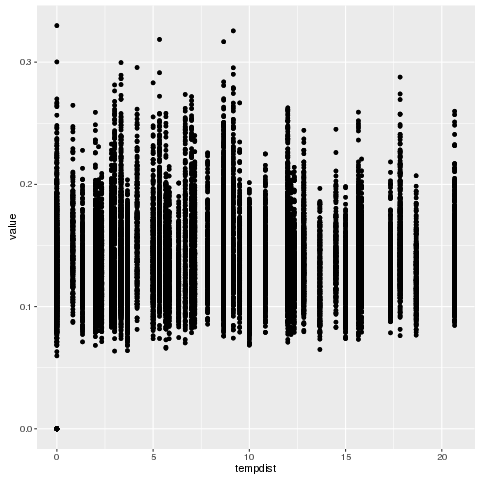

In [47]:
%%R
ggplot(data = df.tot, aes(x = tempdist, y = value)) + geom_point()

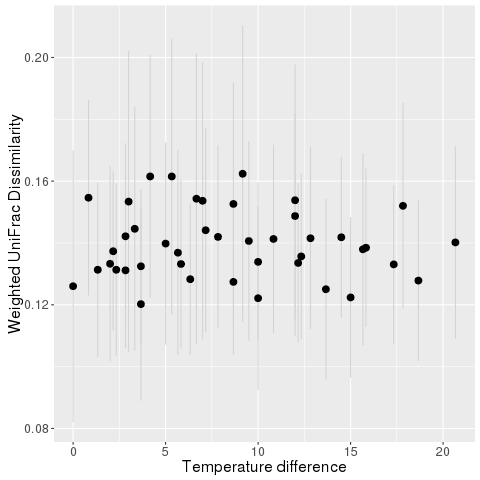

In [48]:
 %%R
mean.tempdist = df.tot %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'light grey')+ 
        geom_point(size = 3) +
    xlab('Temperature difference') + ylab('Weighted UniFrac Dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

In [49]:
%%R
library(ecodist)
mantel(formula = wunif.dist.nopas ~ dist.Temp, nperm = 10000)

    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
0.020242743 0.184800000 0.815300000 0.382000000 0.001902328 0.039003713 


## Split into Treatment

In [50]:
%%R
tbl.meta = physeq.Bulk.core.RFN %>% sample_data
u.lm = tbl.meta$Land_Management %>% unique
u.lm

[1] NTR NTH PTR PTH
Levels: NTH NTR PTH PTR


In [51]:
%%R
physeq.Treat.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core.RFN, Land_Management == d)
    physeq.Treat.l[[d]] = tmp
    print(d)
    physeq.Treat.l[[d]] %>% print
    }

[1] "NTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]
[1] "NTH"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]
[1] "PTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]
[1] "PTH"
phyloseq-class experiment-l

In [52]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    
    MH.dist = phyloseq::distance(physeq, 
                      method = 'unifrac', 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
    return(MH.dist)
    }

MH.dist.treat.l = lapply(physeq.Treat.l, calc.MH.dist, cores=nprocs)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Processing sample...

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [53]:
%%R
#Sample metadata for split physeq objects
physeq.Treat.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core.RFN, Land_Management == d)
    physeq.Treat.meta[[d]] = sample_data(tmp)
    }


In [54]:
%%R
treatments = c('NTR', 'NTH', 'PTR', 'PTH')
str(treatments)

 chr [1:4] "NTR" "NTH" "PTR" "PTH"


In [55]:
%%R

join_temp = function(treatment, dist.mat, metadata, tempdata){
    
    m = data.frame(metadata[[treatment]])
    tempdata = as.data.frame(tempdata)
    dist = dist.mat[[treatment]]
    
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    
    #adding metadata to temperature phlyoseq object
    m$MY = paste(m$Month, m$Year, sep = '-')
    df.Temp = left_join(m, tempdata, by = 'MY')
    
    #Creating temperature distance matrix
    dist.Temp = dist(df.Temp$mean_mean)
    df.T = melt(as.matrix(dist.Temp, varnames = c('T1', 'T2')))
    
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Treatment = treatment

  
    return(df.tot)
    
    
}


temp.data = lapply(treatments, join_temp, metadata = physeq.Treat.meta, dist.mat = MH.dist.treat.l, tempdata = mean_Temp)

In [56]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_temp = function(metadata, tempdata){
    
    #adding metadata to temperature phlyoseq object
    metadata$MY = paste(metadata$Month, metadata$Year, sep = '-')
    df.Temp = left_join(metadata, tempdata, by = 'MY')
    
    #Creating temperature distance matrix
    dist.Temp = dist(df.Temp$mean_mean)
   
    return(dist.Temp)
    
    
}


temp.dist = lapply(physeq.Treat.meta, join_temp, tempdata = mean_Temp)

In [57]:
%%R

plot_by_treatment = function(df.tempdist) {
    
   treatment = unique(df.tempdist$Treatment)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
   mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Temperature difference') + ylab('Weighted Unifrac Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(treatment)

return(p) 
    
}

plots = lapply(temp.data, plot_by_treatment)

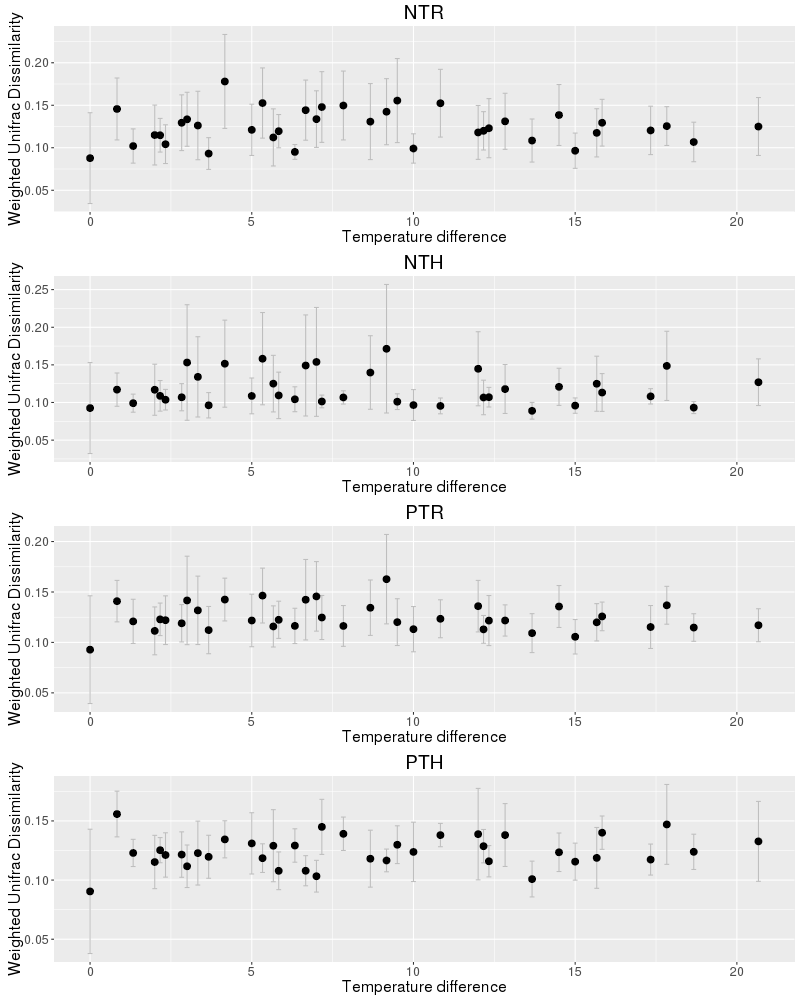

In [58]:
%%R -w 800 -h 1000
do.call(grid.arrange, c(plots,list(ncol=1)))

In [59]:
%%R
mantel.Temp = function(treatment, df.temp, df.dist) {
    
    df.t = df.temp[[treatment]]
    df.d = df.dist[[treatment]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(treatments, df.temp = temp.dist, df.dist = MH.dist.treat.l, mantel.Temp)

In [60]:
%%R
head(m.temp)

[[1]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
 0.02797270  0.29310000  0.70700000  0.62850000 -0.01768822  0.07962505 

[[2]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
 0.02409354  0.31710000  0.68300000  0.68970000 -0.01987146  0.10711780 

[[3]]
     mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
-0.003777414  0.503000000  0.497100000  0.939700000 -0.045460877  0.051552442 

[[4]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.12765755 0.01040000 0.98970000 0.01110000 0.06967936 0.18143243 



## Separation by Replicate - temp vs phylogenetic distance

In [90]:
%%R
#tbl.meta = physeq.Bulk.core.RFN %>% sample_data
#u.lm = tbl.meta$Replicate %>% unique
#u.lm
u.lm = c(1,2,3,4)

In [91]:
%%R
physeq.Rep.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core.RFN, Replicate == d)
    physeq.Rep.l[[d]] = tmp
    print(d)
    physeq.Rep.l[[d]] %>% print
    }

[1] "1"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]
[1] "2"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 43 samples ]
sample_data() Sample Data:       [ 43 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]
[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 43 samples ]
sample_data() Sample Data:       [ 43 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]
[1] "4"
phyloseq-class experiment-level obj

In [92]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq, 
                      method = 'unifrac', 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
    return(MH.dist)
    }

MH.dist.rep.l = lapply(physeq.Rep.l, calc.MH.dist, cores=nprocs)

In [93]:
%%R
#Sample metadata for split physeq objects
physeq.Rep.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.meta[[d]] = sample_data(tmp)
    }


In [95]:
%%R
replicates = c(1,2,3,4)
str(replicates)

 num [1:4] 1 2 3 4


In [96]:
%%R

join_rep = function(replicate, dist.mat, metadata, tempdata){
    
    m = data.frame(metadata[[replicate]])
    tempdata = as.data.frame(tempdata)
    dist = dist.mat[[replicate]]
    
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    
    #adding metadata to temperature phlyoseq object
    m$MY = paste(m$Month, m$Year, sep = '-')
    df.Temp = left_join(m, tempdata, by = 'MY')
    
    #Creating temperature distance matrix
    dist.Temp = dist(df.Temp$mean_mean)
    df.T = melt(as.matrix(dist.Temp, varnames = c('T1', 'T2')))
    
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Replicate = replicate

  
    return(df.tot)
    
    
}


temp.data = lapply(replicates, join_rep, metadata = physeq.Rep.meta, dist.mat = MH.dist.rep.l, tempdata = mean_Temp)

In [97]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_rep = function(metadata, tempdata){
    
    #adding metadata to temperature phlyoseq object
    metadata$MY = paste(metadata$Month, metadata$Year, sep = '-')
    df.Temp = left_join(metadata, tempdata, by = 'MY')
    
    #Creating temperature distance matrix
    dist.Temp = dist(df.Temp$mean_mean)
   
    return(dist.Temp)
    
    
}


temp.dist = lapply(physeq.Rep.meta, join_rep, tempdata = mean_Temp)

In [102]:
%%R

plot_by_replicate = function(df.tempdist) {
    
    replicate = unique(df.tempdist$Replicate)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
    mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

    p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Temperature difference') + ylab('Weighted UniFrac Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(temp.data, plot_by_replicate)

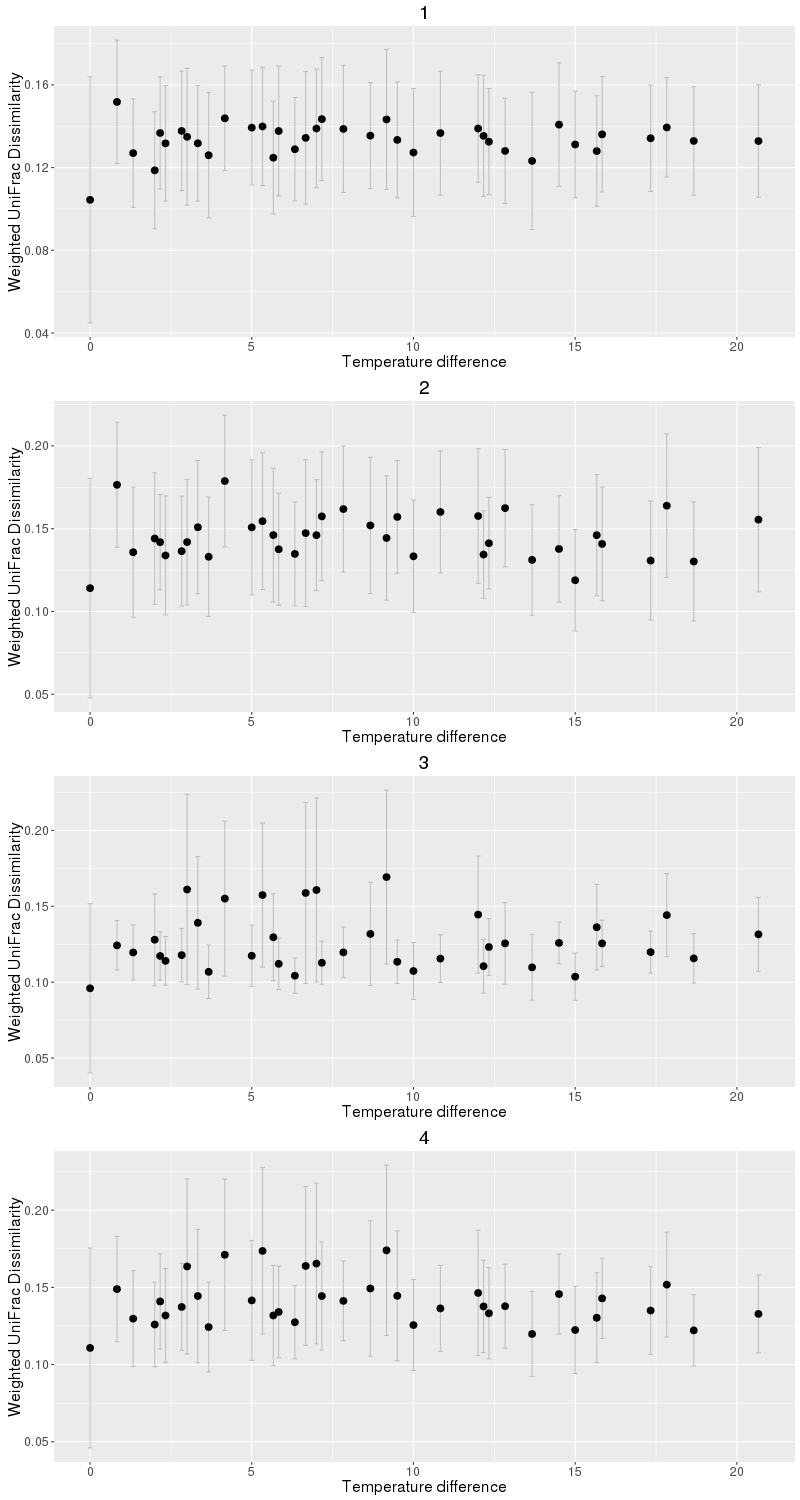

In [103]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [100]:
%%R
mantel.Temp = function(replicate, df.temp, df.dist) {
    
    df.t = df.temp[[replicate]]
    df.d = df.dist[[replicate]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(replicates, df.temp = temp.dist, df.dist = MH.dist.rep.l, mantel.Temp)

In [101]:
%%R
#Results - replicates 1,2,3,4 
m.temp

[[1]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
 0.01229478  0.35980000  0.64030000  0.76990000 -0.04565146  0.06210741 

[[2]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
 0.01454861  0.35970000  0.64040000  0.76300000 -0.03222863  0.05407207 

[[3]]
     mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
 0.031102650  0.260200000  0.739900000  0.587700000 -0.008276947  0.118464236 

[[4]]
     mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
-0.041453519  0.781900000  0.218200000  0.423600000 -0.076077738  0.006825808 



# Sandbox - have not altered/run below

## Phylogenetic distance vs time

In [582]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Land_Management %>% unique
u.lm

[1] NTR PTR NTH PTH
Levels: NTH NTR PTH PTR


In [583]:
%%R
physeq.Treat.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Land_Management == d)
    physeq.Treat.l[[d]] = tmp
    print(d)
    physeq.Treat.l[[d]] %>% print
    }

[1] "NTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]
[1] "PTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]
[1] "NTH"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]
[1] "PTH"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]


In [584]:
%%R
#Sample metadata for split physeq objects
physeq.Treat.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Land_Management == d)
    physeq.Treat.meta[[d]] = sample_data(tmp)
    }


In [585]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.treat.l = lapply(physeq.Treat.l, calc.MH.dist, cores=nprocs)

In [586]:
%%R
treatments = c('NTR', 'PTR', 'NTH', 'PTH')
str(treatments)

 chr [1:4] "NTR" "PTR" "NTH" "PTH"


In [587]:
%%R
physeq.m = physeq.Bulk.core %>% sample_data

join_temp = function(treatment, dist.mat, metadata){
    
    #m = data.frame(metadata[[treatment]])
    dist = dist.mat[[treatment]]

    #dataframe of distances 
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    

    
    physeq.test = plyr::rename(metadata, c("Full.sample"="T1", "Sample_Date"="SD_T1"))
    Test = full_join(df.melt, physeq.test, by = 'T1')
    physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))
    Test2 = full_join(Test, physeq.test2, by = 'T2')
    
    #Creation of relative days distance matrix
    Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)
    Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
    Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))
    Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

    Test2$Day_rel = as.numeric(Test2$Day)
    Test2$Treatment = treatment
  
    return(Test2)
    
    
}


time.data = lapply(treatments, join_temp, metadata = physeq.m, dist.mat = MH.dist.treat.l)

In [588]:
%%R

plot_by_treatment = function(df.timedist) {
    
   treatment = unique(df.timedist$Treatment)
    
   mean.timedist = df.timedist %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.timedist, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) + ggtitle(treatment)

return(p) 
    
}

plots = lapply(time.data, plot_by_treatment)

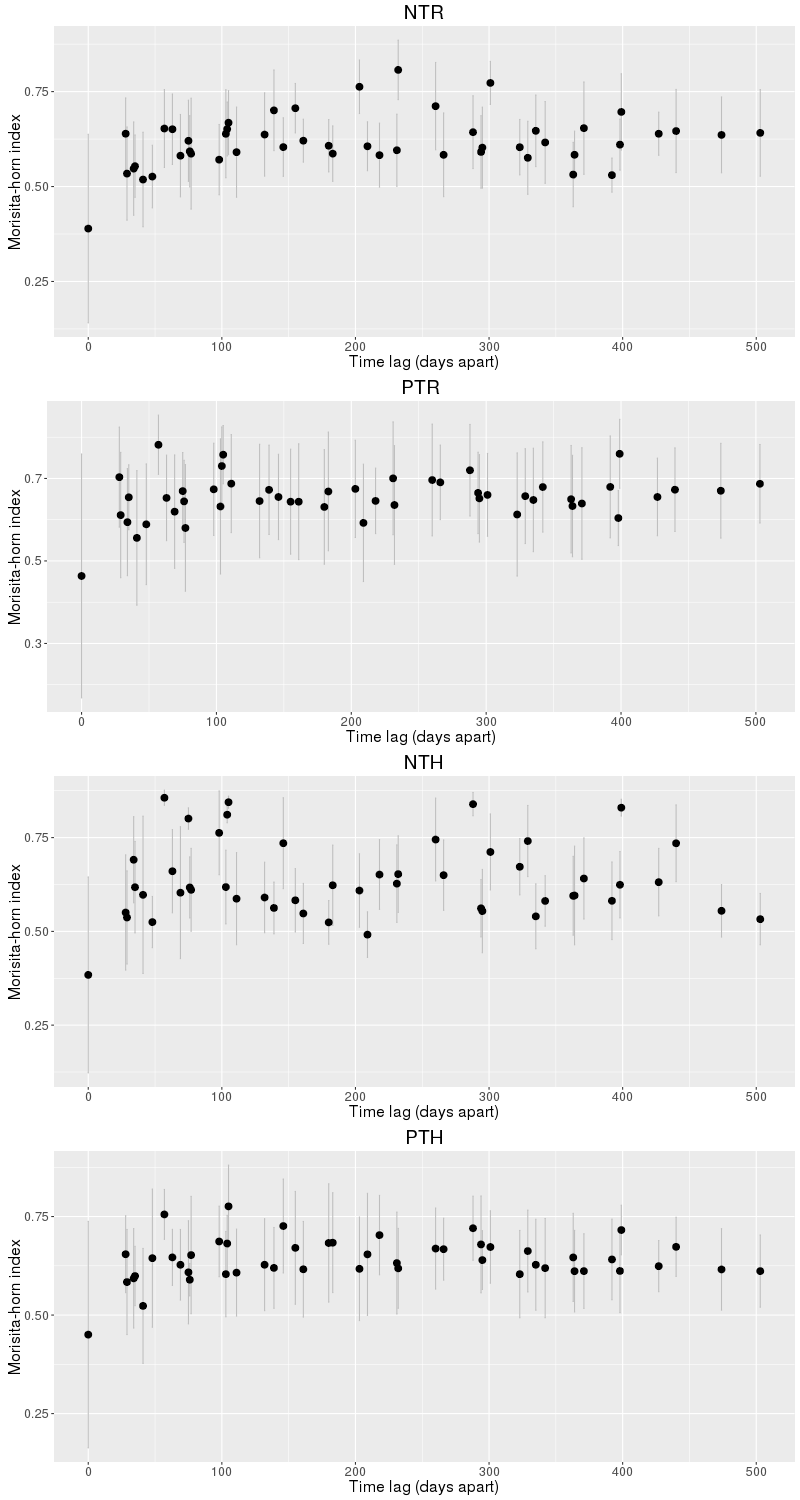

In [589]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [590]:
%%R
make_time_dist = function(physeq.obj) {
    
    physeq.test = sample_data(physeq.obj)

    physeq.test$Sample_Date = as.POSIXct(strptime(physeq.test$Sample_Date , format = "%m/%d/%y"))

    physeq.test$day = round(difftime(physeq.test$Sample_Date, min(physeq.test$Sample_Date), units = "days"))

    physeq.test$d = as.numeric(physeq.test$day)
    
    time_d = dist(physeq.test$d)
    
    return(time_d)
    
}

time_dist = lapply(physeq.Treat.l, make_time_dist)


In [591]:
%%R
mantel.Time = function(treatment, df.time, df.dist) {
    
    df.t = df.time[[treatment]]
    df.d = df.dist[[treatment]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.time = lapply(treatments, df.time = time_dist, df.dist = MH.dist.treat.l, mantel.Time)

In [592]:
%%R
#NTR, PTR, NTH, PTH - order of results
m.time

[[1]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.1687798  0.0025000  0.9976000  0.0025000  0.1144249  0.2266863 

[[2]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.07195900 0.08370000 0.91640000 0.14910000 0.03493738 0.10955676 

[[3]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.08207081 0.05490000 0.94520000 0.07700000 0.03796811 0.12028923 

[[4]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.05164970 0.15490000 0.84520000 0.30480000 0.01983201 0.09513320 



## Time vs phylogenetic distance, by replicate

In [593]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Replicate %>% unique
u.lm

[1] 4 3 1 2


In [594]:
%%R
physeq.Rep.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.l[[d]] = tmp
    print(d)
    physeq.Rep.l[[d]] %>% print
    }

[1] "4"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]
[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]
[1] "1"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]
[1] "2"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]


In [595]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.rep.l = lapply(physeq.Rep.l, calc.MH.dist, cores=nprocs)

In [596]:
%%R
#Sample metadata for split physeq objects
physeq.Rep.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.meta[[d]] = sample_data(tmp)
    }


In [597]:
%%R
replicates = c(4, 3, 1, 2)
str(replicates)

 num [1:4] 4 3 1 2


In [598]:
%%R
physeq.m = physeq.Bulk.core %>% sample_data

join_temp = function(replicate, dist.mat, metadata){
    
    #m = data.frame(metadata[[treatment]])
    dist = dist.mat[[replicate]]

    #dataframe of distances 
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    

    
    physeq.test = plyr::rename(metadata, c("Full.sample"="T1", "Sample_Date"="SD_T1"))
    Test = full_join(df.melt, physeq.test, by = 'T1')
    physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))
    Test2 = full_join(Test, physeq.test2, by = 'T2')
    
    #Creation of relative days distance matrix
    Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)
    Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
    Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))
    Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

    Test2$Day_rel = as.numeric(Test2$Day)
    Test2$Replicate = replicate
  
    return(Test2)
    
    
}


time.data = lapply(replicates, join_temp, metadata = physeq.m, dist.mat = MH.dist.rep.l)

In [599]:
%%R

plot_by_replicate = function(df.timedist) {
    
   replicate = unique(df.timedist$Replicate)
    
   mean.timedist = df.timedist %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.timedist, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(time.data, plot_by_replicate)

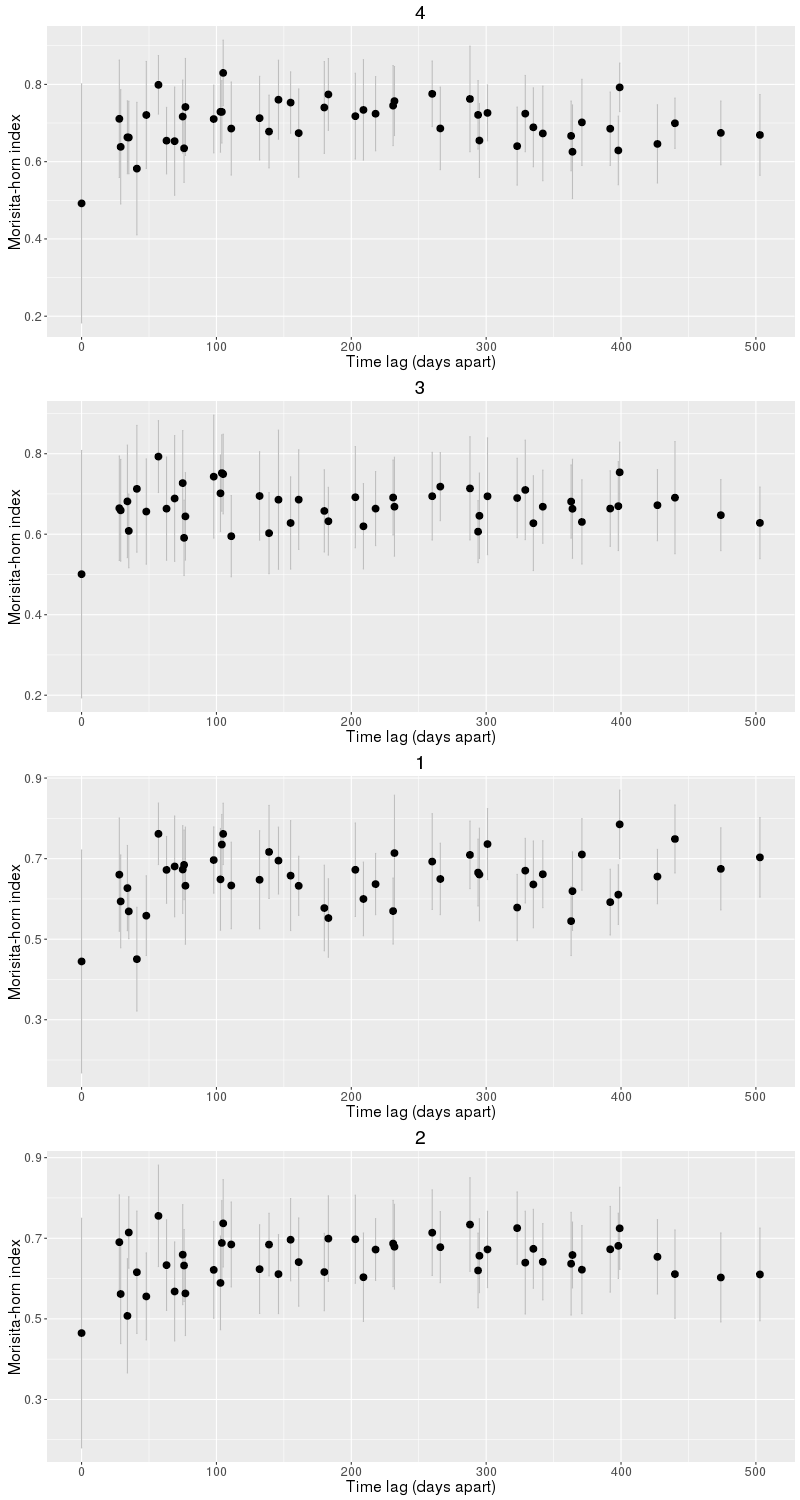

In [600]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [601]:
%%R
make_time_dist = function(physeq.obj) {
    
    physeq.test = sample_data(physeq.obj)

    physeq.test$Sample_Date = as.POSIXct(strptime(physeq.test$Sample_Date , format = "%m/%d/%y"))

    physeq.test$day = round(difftime(physeq.test$Sample_Date, min(physeq.test$Sample_Date), units = "days"))

    physeq.test$d = as.numeric(physeq.test$day)
    
    time_d = dist(physeq.test$d)
    
    return(time_d)
    
}

time_dist = lapply(physeq.Rep.l, make_time_dist)


In [602]:
%%R
mantel.Time = function(replicate, df.time, df.dist) {
    
    df.t = df.time[[replicate]]
    df.d = df.dist[[replicate]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.time = lapply(replicates, df.time = time_dist, df.dist = MH.dist.rep.l, mantel.Time)

In [603]:
%%R
# Order: Replicates 4, 3, 1, 2
m.time

[[1]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
 0.01300611  0.37070000  0.62940000  0.79450000 -0.02380979  0.06026140 

[[2]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
-0.01631991  0.61210000  0.38800000  0.72790000 -0.04531627  0.02527796 

[[3]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.12272634 0.00990000 0.99020000 0.01150000 0.07324088 0.16682439 

[[4]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.09909659 0.02820000 0.97190000 0.03800000 0.06387356 0.13986726 



## By particular class

In [604]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE)
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS", physeq.Bulk)

physeq.Bulk.m = physeq.Bulk.core %>% sample_data
    

physeq.Bulk.core = physeq.Bulk.core %>% transform_sample_counts(function(x) x/sum(x)) 

physeq.Bulk.m = physeq.Bulk.core %>% sample_data

#print(physeq.Bulk.Sparsity)
print(physeq.Bulk.core)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2341 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2341 taxa by 7 taxonomic ranks ]


In [605]:
%%R
physeq.test = subset_taxa(physeq.Bulk.core, Rank1 == 'k__Fungi' & !(is.na(Rank3)))
physeq.test

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2054 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2054 taxa by 7 taxonomic ranks ]


In [606]:
%%R
tax = as.data.frame(tax_table(physeq.test))
Class = unique(tax$Rank3)
Class = list(head(Class, n = 5))
Class

[[1]]
[1] c__Dothideomycetes c__unidentified    c__Agaricomycetes  c__Incertae sedis 
[5] c__Sordariomycetes
27 Levels: c__Agaricomycetes c__Agaricostilbomycetes ... c__Wallemiomycetes



In [607]:
%%R
physeq.class.l = list()

for (d in as.character(Class)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_taxa(physeq.test, Rank3 == d) 
    physeq.class.l[[d]] = tmp
    print(d)
    physeq.class.l[[d]] %>% print
    }


Error in `rownames<-`(`*tmp*`, value = c("sp1", "sp0")) : 
  length of 'dimnames' [1] not equal to array extent


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 41 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [608]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.class.l = lapply(physeq.class.l, calc.MH.dist, cores=nprocs)

In [609]:
%%R
#Sample metadata for split physeq objects
physeq.C.meta = list()

for (d in as.character(Class)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_taxa(physeq.test, Rank3 == d)
    physeq.C.meta[[d]] = sample_data(tmp)
    }



Error in `rownames<-`(`*tmp*`, value = c("sp1", "sp0")) : 
  length of 'dimnames' [1] not equal to array extent


In [610]:
%%R
physeq.m = physeq.test %>% sample_data

join_temp = function(Class, dist.mat, metadata){

    dist = dist.mat[[Class]]
    #return(dist)
    #dataframe of distances 
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    

    
    physeq.test = plyr::rename(metadata, c("Full.sample"="T1", "Sample_Date"="SD_T1"))
    Test = full_join(df.melt, physeq.test, by = 'T1')
    physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))
    Test2 = full_join(Test, physeq.test2, by = 'T2')
    
    #Creation of relative days distance matrix
    Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)
    Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
    Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))
    Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

    Test2$Day_rel = as.numeric(Test2$Day)
    Test2$Class = Class
  
    return(Test2)
    
    
}


time.data = lapply(Class, join_temp, metadata = physeq.m, dist.mat = MH.dist.class.l)


Error in dist.mat[[Class]] : no such index at level 1


In [611]:
%%R

plot_by_class = function(df.timedist) {
    
   class = unique(df.timedist$Class)
    
   mean.timedist = df.timedist %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))
    return(mean.timedist)
p = ggplot(data = mean.timedist, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(time.data, plot_by_class)

In [612]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))


Error in gList(list(Day_rel = c(0, 28, 29, 34, 35, 41, 48, 57, 63, 69,  : 
  only 'grobs' allowed in "gList"


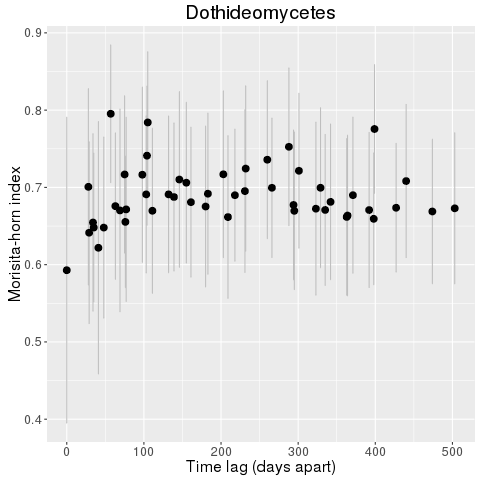

In [613]:
%%R

mean.timedist = Test2 %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

limits <- aes(ymax = meanval + sdval, ymin = meanval - sdval)


p = ggplot(data = mean.timedist, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) + ggtitle("Dothideomycetes")

p

In [614]:
%%R
 physeq.mtest = sample_data(physeq.test)

physeq.mtest$Sample_Date = as.POSIXct(strptime(physeq.mtest$Sample_Date , format = "%m/%d/%y"))

physeq.mtest$day = round(difftime(physeq.mtest$Sample_Date, min(physeq.mtest$Sample_Date), units = "days"))

physeq.mtest$d = as.numeric(physeq.mtest$day)
    
time_d = dist(physeq.mtest$d)
    

    


In [615]:
%%R
library(ecodist)
mantel(formula = MH.dist ~ time_d, nperm = 10000)


Error in eval(expr, envir, enclos) : object 'MH.dist' not found
